# Modeling and Simulation in Python

Chapter 3:

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [64]:
# If you want the figures to appear in the notebook, use
# %matplotlib notebook

# If you want the figures to appear in separate windows, use
# %matplotlib qt

# To switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

In [65]:
from pandas import read_html

In [66]:
# The data directory contains a downloaded copy of
# https://en.wikipedia.org/wiki/World_population_estimates

filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')

In [67]:
table2 = tables[2]
table2.head()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2007)[15],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2525149000,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2572850917,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2619292068,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2665865392,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2713172027,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
table2.tail()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2007)[15],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,,
2011,6944055583,6.986951e+09,6997998760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,7022349283,7.057075e+09,7080072417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,7101027895,7.136796e+09,7162119434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,7178722893,7.238184e+09,7243784000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,7256490011,7.336435e+09,7349472000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [70]:
table2

,census,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2525149000,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2572850917,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2619292068,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2665865392,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2713172027,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955,2782098943,NaN,2761650981,2.769074e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,2835299673,NaN,2811572031,2.822502e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,2891349717,NaN,2863042795,2.879934e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958,2948137248,NaN,2916030167,2.939254e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
census = table2.census
census

Year
1950    2557628654
1951    2594939877
1952    2636772306
1953    2682053389
1954    2730228104
1955    2782098943
1956    2835299673
1957    2891349717
1958    2948137248
1959    3000716593
1960    3043001508
1961    3083966929
1962    3140093217
1963    3209827882
1964    3281201306
1965    3350425793
1966    3420677923
1967    3490333715
1968    3562313822
1969    3637159050
1970    3712697742
1971    3790326948
1972    3866568653
1973    3942096442
1974    4016608813
1975    4089083233
1976    4160185010
1977    4232084578
1978    4304105753
1979    4379013942
           ...    
1986    4940571232
1987    5027200492
1988    5114557167
1989    5201440110
1990    5288955934
1991    5371585922
1992    5456136278
1993    5538268316
1994    5618682132
1995    5699202985
1996    5779440593
1997    5857972543
1998    5935213248
1999    6012074922
2000    6088571383
2001    6165219247
2002    6242016348
2003    6318590956
2004    6395699509
2005    6473044732
2006    6551263534
2007   

In [72]:
census.values

array([2557628654, 2594939877, 2636772306, 2682053389, 2730228104,
       2782098943, 2835299673, 2891349717, 2948137248, 3000716593,
       3043001508, 3083966929, 3140093217, 3209827882, 3281201306,
       3350425793, 3420677923, 3490333715, 3562313822, 3637159050,
       3712697742, 3790326948, 3866568653, 3942096442, 4016608813,
       4089083233, 4160185010, 4232084578, 4304105753, 4379013942,
       4451362735, 4534410125, 4614566561, 4695736743, 4774569391,
       4856462699, 4940571232, 5027200492, 5114557167, 5201440110,
       5288955934, 5371585922, 5456136278, 5538268316, 5618682132,
       5699202985, 5779440593, 5857972543, 5935213248, 6012074922,
       6088571383, 6165219247, 6242016348, 6318590956, 6395699509,
       6473044732, 6551263534, 6629913759, 6709049780, 6788214394,
       6866332358, 6944055583, 7022349283, 7101027895, 7178722893,
       7256490011])

In [73]:
census.index

Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
           dtype='int64', name='Year')

In [74]:
type(table2)

pandas.core.frame.DataFrame

In [75]:
type(census)

pandas.core.series.Series

In [76]:
type(census.index)

pandas.core.indexes.numeric.Int64Index

In [77]:
type(census.values)

numpy.ndarray

In [137]:
def plot_estimates(table):
    un = table.un / 1e9
    census = table.census / 1e9
    
    plot(census, ':', color='darkblue', label='US Census')
    plot(un, '--', color='green', label='UN DESA')
    
    decorate(xlabel='Year', xlim=[1949, 2016],
             ylabel='World population (billion)')

<IPython.core.display.Javascript object>


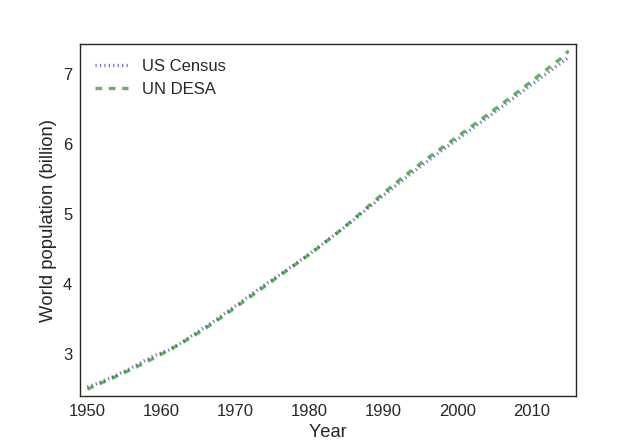

Saving figure to file chap03-fig01.pdf


In [138]:
newfig()
plot_estimates(table2)
savefig('chap03-fig01.pdf')

In [80]:
un = table2.un / 1e9

In [81]:
census = table2.census / 1e9

In [83]:
max(abs(census - un) / un)

0.012862470293832286

### Constant growth

In [84]:
census[1950]

2.5576286540000002

In [85]:
census[2015]

7.2564900110000004

In [86]:
first_year = census.index[0]
last_year = census.index[-1]
first_year, last_year

(1950, 2015)

In [87]:
total_growth = census[last_year] - census[first_year]
elapsed_time = last_year - first_year
annual_growth = total_growth / elapsed_time
annual_growth

0.07229017472307693

In [88]:
model = Series([])

In [89]:
model[1950] = census[1950]
model

1950    2.557629
dtype: float64

In [90]:
for year in arange(1951, 2016):
    model[year] = model[year-1] + annual_growth

<IPython.core.display.Javascript object>


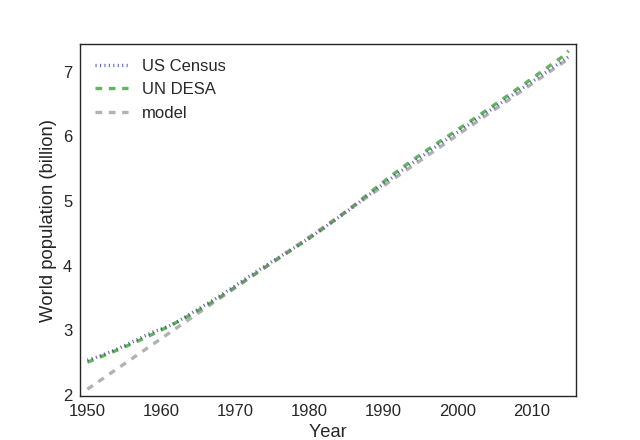

Saving figure to file chap03-fig02.pdf


In [139]:
newfig()
plot_estimates(table2)
plot(model, '--', color='gray', label='model')
decorate(xlabel='Year', ylabel='World population (billion)')
savefig('chap03-fig02.pdf')

**Exercise:**  Try fitting the model using data from 1965 to the present, and see if that does a better job of fitting the data.

Note: Make sure your model starts in 1950, even though the estimated annual growth is based on later data.  You might have to shift the first value in the series up or down to match the data.

<IPython.core.display.Javascript object>


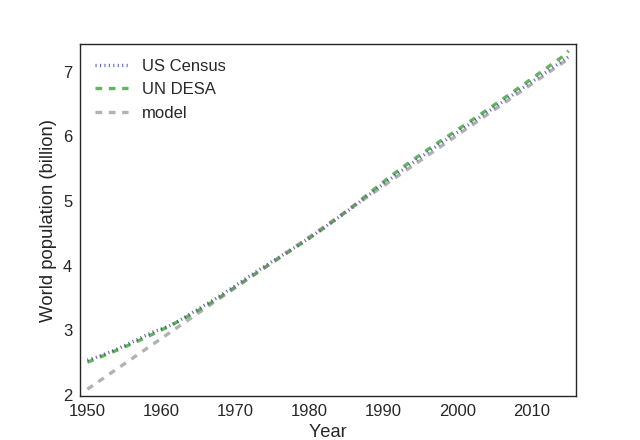

In [140]:
# Solution

first_year = 1970
last_year = census.index[-1]
total_growth = census[last_year] - census[first_year]
elapsed_time = last_year - first_year
annual_growth = total_growth / elapsed_time

model = Series([])
model[1950] = census[1950] - 0.45
for year in arange(1951, 2016):
    model[year] = model[year-1] + annual_growth
    
newfig()
plot_estimates(table2)
plot(model, '--', color='gray', label='model')
decorate(xlabel='Year', ylabel='World population (billion)')

### Now with state objects

In [141]:
t0 = census.index[0]
t_end = census.index[-1]
total_growth = census[t_end] - census[t0]
elapsed_time = t_end - t0
annual_growth = total_growth / elapsed_time

In [142]:
state = State(t0=t0, 
              t_end=t_end,
              init=census[t0],
              annual_growth=annual_growth)

In [143]:
def run_model1(state):
    """Runs the constant growth model.
    
    Adds `model` to the state object
    
    state: State object
    """
    model = Series([])
    model[state.t0] = state.init
    for year in arange(state.t0+1, state.t_end+1):
        model[year] = model[year-1] + state.annual_growth
    state.model = model

In [144]:
def plot_model(state):
    """Plot the estimates and the model.
    
    state: State object with a state variable `model`
    """
    newfig()
    plot_estimates(table2)
    plot(state.model, '--', color='gray', label='model')
    decorate(xlabel='Year', 
             ylabel='World population (billion)')

<IPython.core.display.Javascript object>


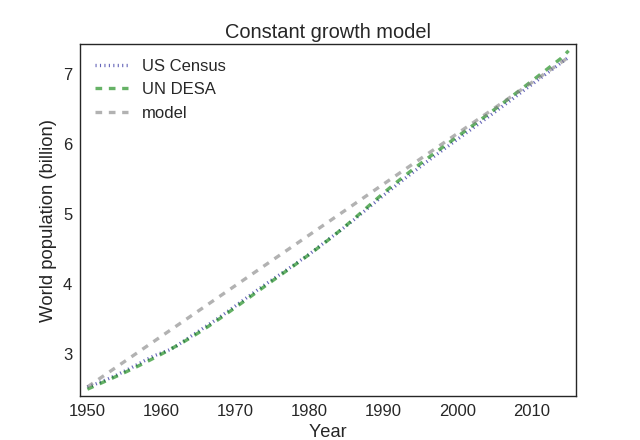

In [154]:
run_model1(state)
plot_model(state)
title('Constant growth model')

**Exercise:** The constant growth model doesn't make a lot of sense, because it seems like the number of deaths and births should depend on the size of the population.  As a small improvement, let's write a version of `run_model1` where the number of deaths is proportional to the size of the population, but the number of births is constant.  This model doesn't make a lot of sense, either, but it's a good exercise.

Write a function called `run_model1b` that implements a model where the number of births is constant, but the number of deaths is proportional to the current size of the population.  Set the death rate to `0.01`, which means that 1% of the population dies each year; then choose the number of annual births to make the model fit the data as well as you can.

Hint: It probably won't fit very well.

In [155]:
# Solution

def run_model1b(state):
    model = Series([])
    model[state.t0] = state.init
    for year in arange(state.t0+1, state.t_end+1):
        deaths = state.death_rate * model[year-1]
        model[year] = model[year-1] + state.annual_births - deaths
    state.model = model

<IPython.core.display.Javascript object>


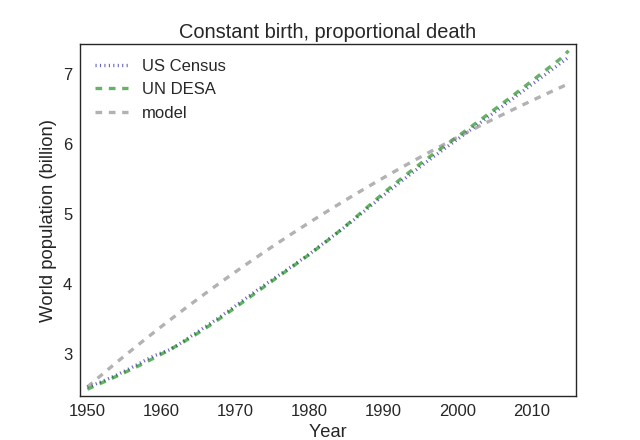

In [156]:
# Solution

state.death_rate = 0.01
state.annual_births = annual_growth * 1.6

run_model1b(state)
plot_model(state)
title('Constant birth, proportional death')

## Proportional death, proportional birth

In [157]:
def run_model2(state):
    model = Series([])
    model[state.t0] = state.init
    for year in arange(state.t0+1, state.t_end+1):
        births = state.birth_rate * model[year-1]
        deaths = state.death_rate * model[year-1]
        model[year] = model[year-1] + births - deaths
    state.model = model

In [158]:
state.death_rate = 0.01
state.birth_rate = 0.027

<IPython.core.display.Javascript object>


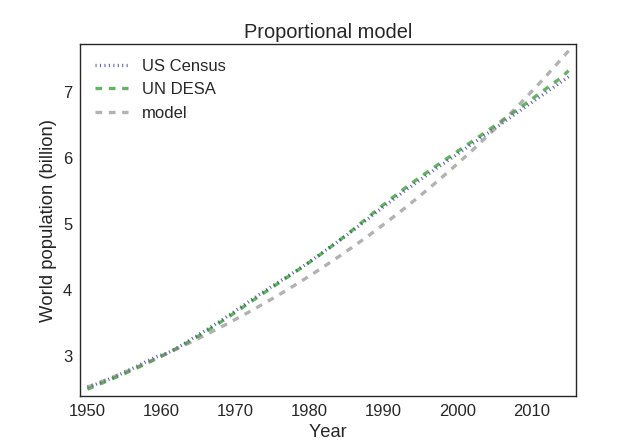

Saving figure to file chap03-fig03.pdf


In [159]:
run_model2(state)
plot_model(state)
title('Proportional model')
savefig('chap03-fig03.pdf')

**Exercise:** In this implementation, we compute the number of deaths and births separately, but since they are both proportional to the current population, we can combine them.

Write a function called `run_model2b` that implements a model with a single parameter, `alpha`, that represents the net growth rate, which is the difference between the birth and death rates.  For example, if `alpha=0.01`, the population should grow by 1% per year.

Choose the value of `alpha` that fits the data best.

In [160]:
def run_model2b(state):
    model = Series([])
    model[state.t0] = state.init
    for year in arange(state.t0+1, state.t_end+1):
        net_growth = state.alpha * model[year-1]
        model[year] = model[year-1] + net_growth
    state.model = model

<IPython.core.display.Javascript object>


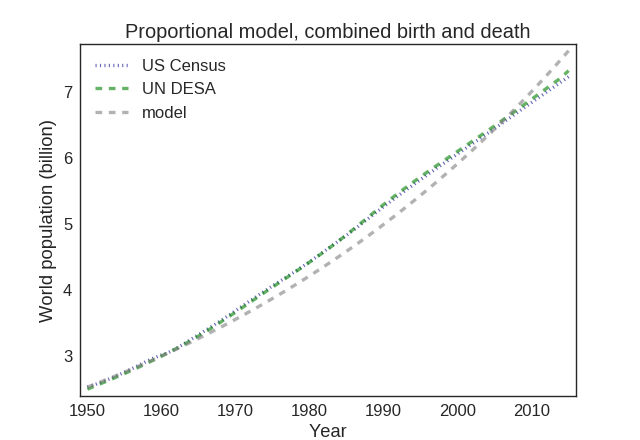

In [162]:
state.alpha = 0.017

run_model2b(state)
plot_model(state)
title('Proportional model, combined birth and death')

### Factoring out the update function

In [182]:
def update_func1(year, pop, state):
    """Compute the population next year.
    
    year: current year
    pop: current population
    state: State object containing parameters of the model
    
    returns: population next year
    """
    births = state.birth_rate * pop
    deaths = state.death_rate * pop
    return pop + births - deaths

In [183]:
update_func1

<function __main__.update_func1>

In [184]:
type(update_func1)

function

In [185]:
def run_any_model(state, update_func):
    """Run a model.
    
    state: State object
    update_func: function that computes the population next year
    """
    model = Series([])
    model[state.t0] = state.init
    for year in arange(state.t0+1, state.t_end+1):
        pop = model[year-1]
        model[year] = update_func(year, pop, state)
    state.model = model

In [186]:
run_any_model(state, update_func1)

<IPython.core.display.Javascript object>


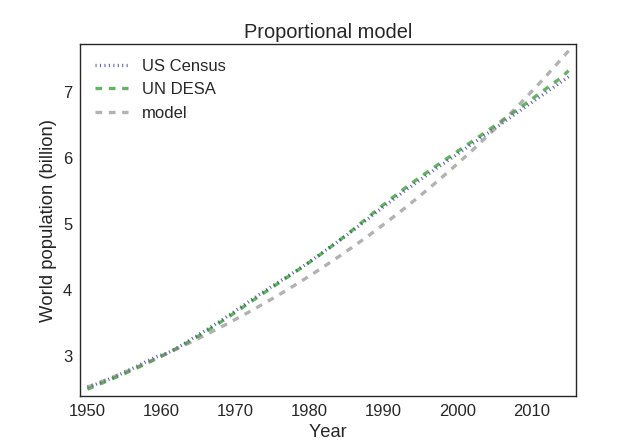

In [187]:
plot_model(state)
title('Proportional model')

**Exercise:** When you run `run_any_model`, it runs `update_func1` once for each year between `t0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `year` and `pop`, then run `run_any_model` again.

### Combining birth and death

In [174]:
def update_func1b(year, pop, state):
    net_growth = state.alpha  * pop
    return pop + net_growth

<IPython.core.display.Javascript object>


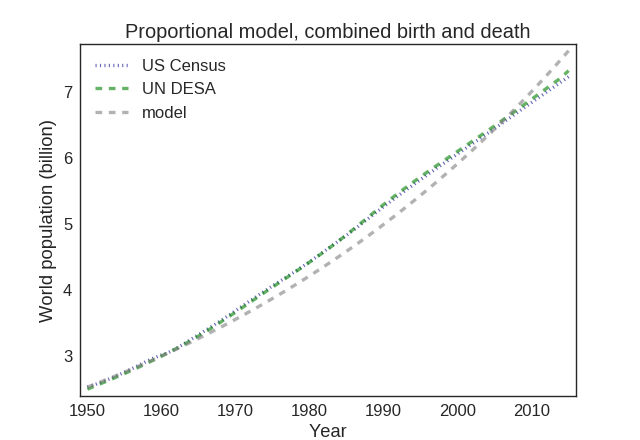

In [188]:
state.alpha = state.birth_rate - state.death_rate

run_any_model(state, update_func1b)
plot_model(state)
title('Proportional model, combined birth and death')

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, might be changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write a function called `update_func1c` that takes `year`, `pop`, and `state` as parameters.  The state object, `state`, should contains two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should compute and return the simulated population one year later.

Note: Don't forget the `return` statement.

In [189]:
# Solution

def update_func1c(year, pop, state):
    if year < 1980:
        net_growth = state.alpha1 * pop
    else:
        net_growth = state.alpha2 * pop
    return pop + net_growth

<IPython.core.display.Javascript object>


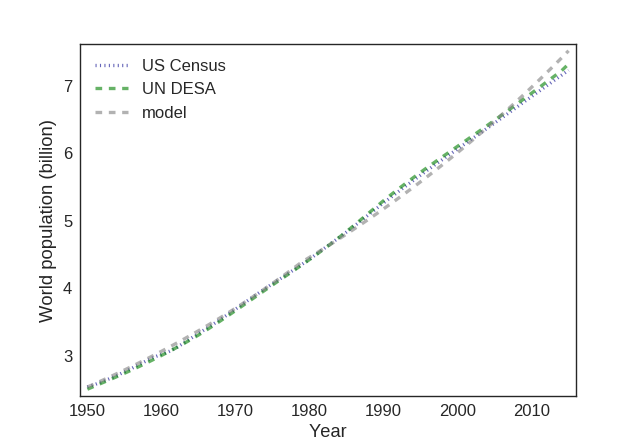

In [190]:
state.alpha1 = 0.019
state.alpha2 = 0.015

run_any_model(state, update_func1c)
plot_model(state)
title('Proportional model, parameter changes over time')

### Quadratic growth

In [111]:
def update_func3(year, pop, state):
    net_growth = state.alpha * pop + state.beta * pop**2
    return pop + net_growth

<IPython.core.display.Javascript object>


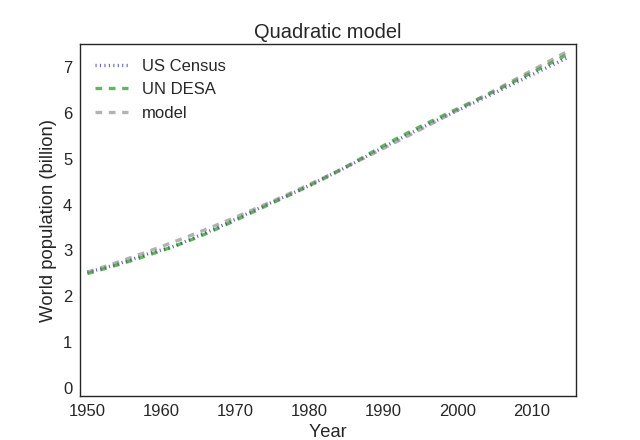

Saving figure to file chap03-fig04.pdf


In [193]:
state.alpha = 0.025
state.beta = -0.0018

run_any_model(state, update_func3)
plot_model(state)
title('Quadratic model')
savefig('chap03-fig04.pdf')

In [211]:
pop_array = linspace(0.001, 15, 100)
net_growth_array = state.alpha * pop_array + state.beta * pop_array**2

<IPython.core.display.Javascript object>


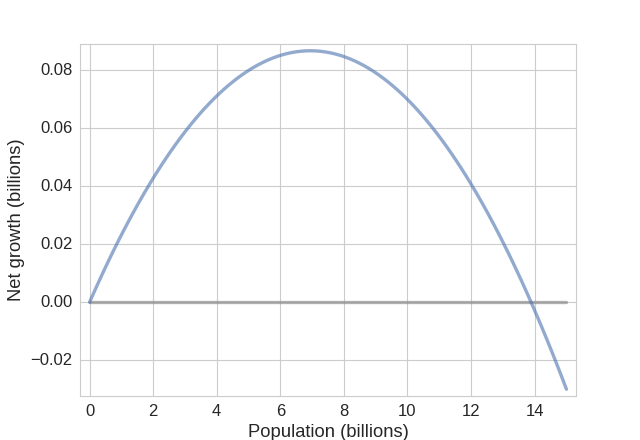

Saving figure to file chap03-fig05.pdf


In [229]:
newfig()
sns.set(style='whitegrid', font_scale=1.5)
plot(pop_array, net_growth_array, '-')
decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)',
         legend=False)
savefig('chap03-fig05.pdf')

**Exercise:** Reparameterize.  TODO: fill in details

In [113]:
state.r = state.alpha
state.K = -state.alpha/state.beta

state.r, state.K

(0.025, 13.88888888888889)

In [114]:
def update_func3b(year, pop, state):
    net_growth = state.r * pop * (1 - pop / state.K)
    return pop + net_growth

<IPython.core.display.Javascript object>


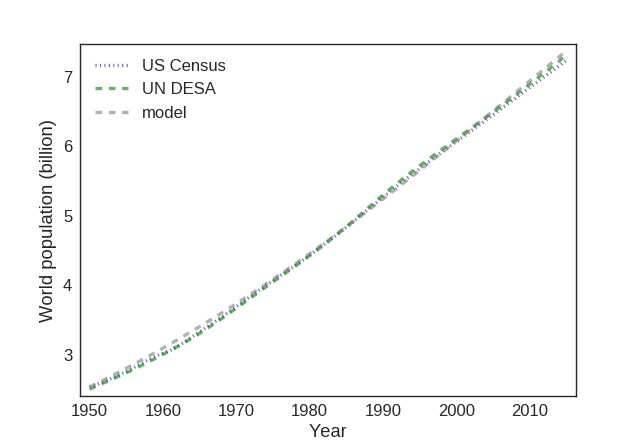

In [115]:
run_any_model(state, update_func3b)
plot_model(state)

### Generating projections

<IPython.core.display.Javascript object>


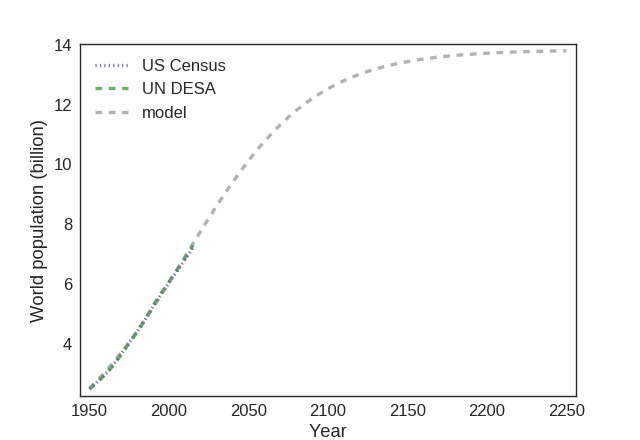

In [116]:
state.t_end = 2250
run_any_model(state, update_func3)
plot_model(state)

In [117]:
state.model[state.t_end]

13.856665141368708

### Comparing projections

In [118]:
table3 = tables[3]
table3.head()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973-2015)[6],United Nations Department of Economic and Social Affairs (2015)[7]
Year,,,
2016,7.334772e+09,NaN,7.432663e+09
2017,7.412779e+09,NaN,NaN
2018,7.490428e+09,NaN,NaN
2019,7.567403e+09,NaN,NaN
2020,7.643402e+09,NaN,7.758157e+09


In [119]:
table3

,United States Census Bureau (2015)[18],Population Reference Bureau (1973-2015)[6],United Nations Department of Economic and Social Affairs (2015)[7]
Year,,,
2016,7.334772e+09,NaN,7.432663e+09
2017,7.412779e+09,NaN,NaN
2018,7.490428e+09,NaN,NaN
2019,7.567403e+09,NaN,NaN
2020,7.643402e+09,NaN,7.758157e+09
2021,7.718257e+09,NaN,NaN
2022,7.792021e+09,NaN,NaN
2023,7.864725e+09,NaN,NaN
2024,7.936272e+09,NaN,NaN


In [120]:
table3.columns = ['census', 'prb', 'un']

In [121]:
def plot_projections(table):
    census = table.census / 1e9
    un = table.un / 1e9
    
    plot(census, ':', color='darkblue', label='US Census')
    plot(un.dropna(), '--', color='green', label='UN DESA')
    
    plt.fill_between([2016, 2105], [0, 0], [13, 13], color='0.95')

<IPython.core.display.Javascript object>


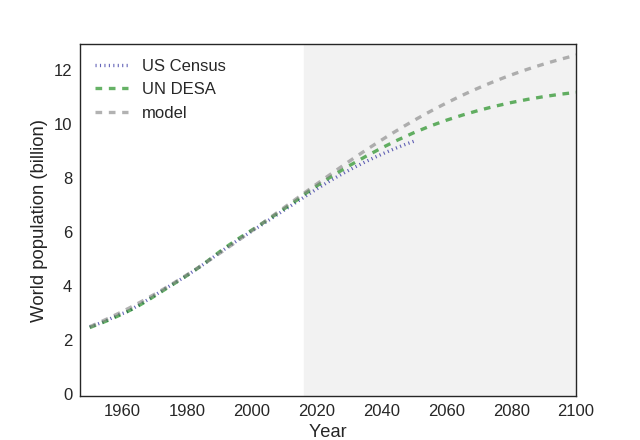

In [122]:
plot_model(state)
plot_projections(table3)
decorate(xlim=[1947, 2100], ylim=[0, 13])

**Exercise:** On the Wikipedia page about world population estimates, the first table contains estimates for prehistoric populations.  The following cells process this table and plot some of the results.

In [123]:
table1 = tables[1]
table1.head()

,Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2010)[citation needed],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,
-10000,NaN,NaN,NaN,2M[15],NaN,NaN,4.0,1–10M,NaN,NaN
-9000,NaN,NaN,NaN,4.,NaN,NaN,NaN,NaN,NaN,NaN
-8000,5.0,NaN,NaN,5.,NaN,NaN,NaN,NaN,5–10M,NaN
-7000,NaN,NaN,NaN,8.,NaN,NaN,NaN,NaN,NaN,NaN
-6000,NaN,NaN,NaN,11.,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
table1.tail()

,Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2010)[citation needed],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,
1913,NaN,NaN,1793.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,NaN,1860.0,1863.,1912.,NaN,NaN,NaN,NaN,NaN,1968.
1925,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,NaN
1930,NaN,2070.0,NaN,2092.,NaN,NaN,NaN,NaN,NaN,2145.
1940,NaN,2300.0,2299.,2307.,NaN,NaN,NaN,NaN,NaN,2340.


In [125]:
table1.replace('M', np.nan, regex=True, inplace=True)

In [126]:
table1.columns = ['prb', 'un', 'maddison', 'hyde', 'tanton', 
                  'biraben', 'mj', 'thomlinson', 'durand', 'clark']

In [127]:
def plot_prehistory(table):
    plot(table.prb, 'ro', label='PRB')
    plot(table.un, 'co', label='UN')
    plot(table.hyde, 'yo', label='HYDE')
    plot(table.tanton, 'go', label='Tanton')
    plot(table.biraben, 'bo', label='Biraben')
    plot(table.mj, 'mo', label='McEvedy & Jones')

<IPython.core.display.Javascript object>


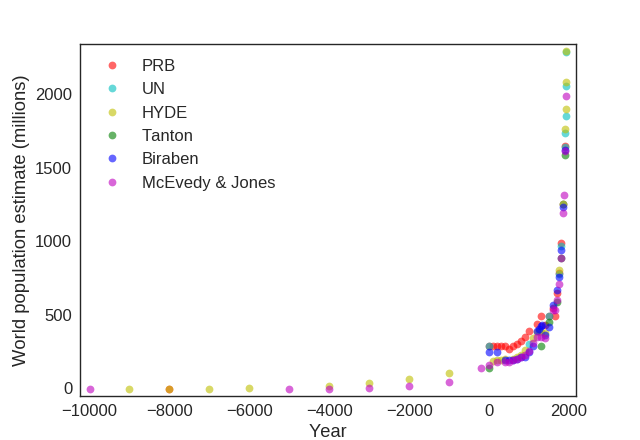

In [128]:
newfig()
plot_prehistory(table1)
decorate(xlabel='Year', 
         ylabel='World population estimate (millions)')

<IPython.core.display.Javascript object>


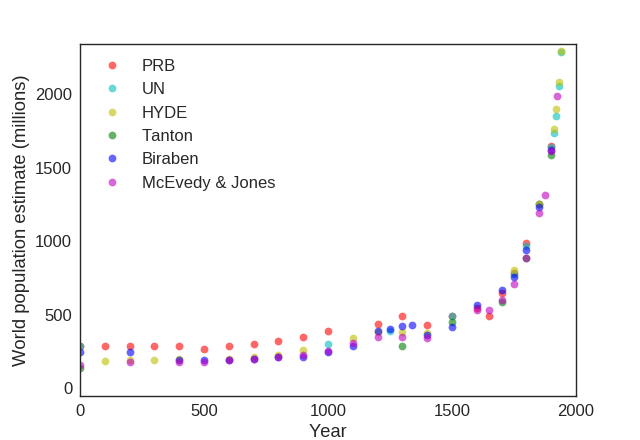

In [63]:
newfig()
plot_prehistory(table1)
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population estimate (millions)')

See if you can find a model that fits these data well from Year -1000 to 1940, or from Year 0 to 1940.  How well does your best model predict actual population growth from 1950 to the present?